In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.utils import fill_infos

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(294697)

***
# Data import

In [2]:
chunk_size = 100000
sample_size_percent = 5

data = pd.DataFrame()

for chunk in pd.read_csv("./datas/en.openfoodfacts.org.products.csv", sep="\t", nrows=None, chunksize=chunk_size):
    actual_chunk_size = chunk.shape[0]
    random_size = int(actual_chunk_size * (sample_size_percent / 100))
    random_indexes = np.random.default_rng().choice(chunk.index, size=random_size, replace=False)
    chunk = chunk.loc[random_indexes]
    data = pd.concat([data, chunk])
    del chunk

data.shape

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,27,28,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,8,13,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_as

(95365, 186)

## Dataset overview

In [3]:
rows_nb, cols_nb = data.shape

In [4]:
data.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
79709,36800318571,http://world-en.openfoodfacts.org/product/0036...,org-database-usda,1587670601,2020-04-23T19:36:41Z,1587670601,2020-04-23T19:36:41Z,Beef ravioli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States,"Enriched durum flour (wheat flour, niacin, iro...","en:eggs,en:gluten,en:milk",NaN,NaN,NaN,NaN,9 PIECES (146 g),146.0,NaN,2.0,NaN,"en:e150c,en:e407","E150c - Ammonia caramel,E407 - Carrageenan",0.0,NaN,NaN,0.0,NaN,NaN,-1.0,a,4.0,Cereals and potatoes,Cereals,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...","To

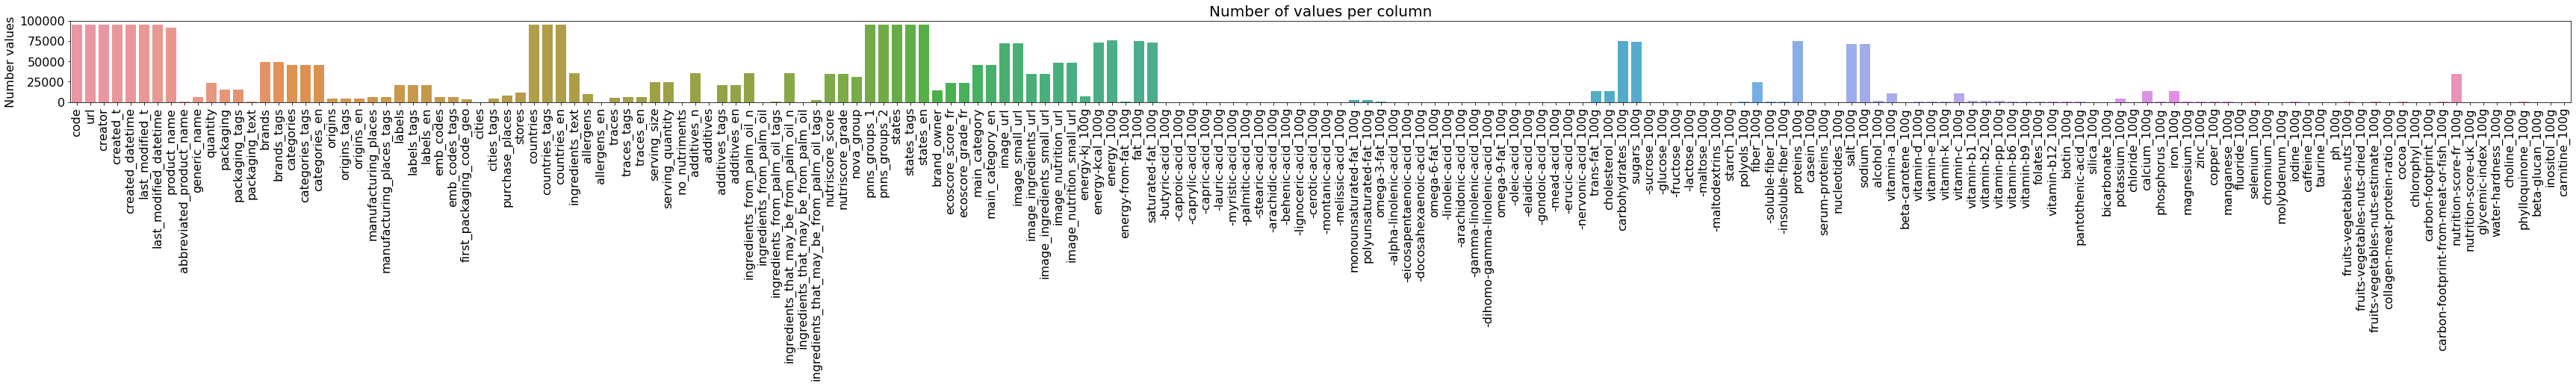

In [5]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=data.columns, y=data.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=90, size=16)
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
# Nutriscore

## Nutriscore feature analysis

In [9]:
nutriscore_features = [
    "fruits-vegetables-nuts_100g",
    "proteins_100g",
    "fiber_100g",
    "sugars_100g",
    "salt_100g",
    "saturated-fat_100g",
    "energy-kcal_100g"
]

In [10]:
nutriscore_data = data.loc[:, ["nutriscore_score", "nutriscore_grade", "nutrition-score-fr_100g"]]
nutriscore_data.head(10)

,nutriscore_score,nutriscore_grade,nutrition-score-fr_100g
79709,-1.0,a,-1.0
64937,NaN,NaN,NaN
71244,29.0,e,29.0
55125,NaN,NaN,NaN
8327,NaN,NaN,NaN
45913,17.0,d,17.0
9719,NaN,NaN,NaN
29075,9.0,c,9.0
24215,NaN,NaN,NaN
764,17.0,d,17.0


In [11]:
na = nutriscore_data.any(axis="columns")
print("at least one value: ", na.sum())
print("nutriscore_grade recorded: ", data.nutriscore_grade.notna().sum())
print("all rows: ", na.count())

at least one value:  34927
nutriscore_grade recorded:  34927
all rows:  95365


Too few entries have nutriscore cell filled, around 33%.
Could be a way to calculate it manually from other fields ?

## Nutriscore needed data

Is there a way to calculate Nutriscore from the others information ?

For that, we need to have the P and N ingredients of the nutriscore formula.

P (positive) ingredients:
- fruits, vegetable, nuts
- proteins
- fiber

N (negative) ingredients:
- sugar
- salt
- saturated fatty acid
- energy (kcal)

In [6]:
p = [
    "fruit",
    "vegetable",
    "nuts",
    "olive",
    "fiber"
]

In [7]:
n = [
    "sugar",
    "sodium",
    "saturated fatr"
]

## Search for needed fields/features

In [8]:
results = []
for ingredient in p + n:
    for column in data.columns:
        if ingredient in column:
            results.append(column)
print(len(results))
results

14


['fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fiber_100g',
 '-soluble-fiber_100g',
 '-insoluble-fiber_100g',
 'sugars_100g',
 'sodium_100g']

## Nutriscore's features content analysis

They are the fields needed for the nutriscore formulas, but:
- "fruits-vegetables-nuts_100g": completely empty
- "fiber": too fews records, but could simply be due to the fact not all product contains fiber

## Where are the fruits, vegetables and nuts ?

In [12]:
pd.set_option('display.max_colwidth', None)

ingredient_text_data = data[data.ingredients_text.notna()].ingredients_text
ingredient_text_data.head(5)

79709                                                                                                                                                                                                                                             Enriched durum flour (wheat flour, niacin, iron, thiamin mononitrate, riboflavin, folic acid), water, beef, ricotta cheese (whey, milk, cream, vinegar, carrageenan), eggs, bread crumbs (enriched flour [wheat flour, niacin, reduced iron, thiamin mononitrate, riboflavin, folic acid], sugar, soybean oil, yeast), contains less than 2% of: spice blend (spices, parsley, garlic powder), onion, caramel color, salt.
64937                                                                                                                                                                                                                                                                                                                                                      

In [68]:
def search(row, col: str, match: list):
    for m in match:
        if m in row[col]:
            print("row[col]: ", row[col])
            # return row[col].index

data[data.ingredients_text.notna()].iloc[:10].apply(lambda row: search(row, "ingredients_text", p), axis=1)

row[col]:  Apple fruit filling (mixed fruit juice concentrate [pineapple, peach, apple, pear], apples, tapioca starch, currants, natural flavor, water, citric acid, pectin, cinnamon, locust bean gum, annatto extract and turmeric for color), oats, gluten free flour b
row[col]:  Skim milk, cream, sugar, black walnuts, corn syrup, whey, contains 2% or less of: mono - and diglycerides, guar gum, calcium sulfate, locust bean gum, carrageenan, black walnut extract, caramel (for color).
row[col]:  Tomato puree (water, tomato paste), romano cheese (pasteurized cow's milk, cheese cultures, salt, enzymes), parmesan cheese (pasteurized part-skim cow's milk, cheese cultures, salt, enzymes), less than 2% of: sugar, salt, vegetable oil (soybean oil and/or canola oil), dehydrated onion, ricotta cheese (whey ricotta, salt), citric acid, spices, dehydrated garlic.


79709    None
64937    None
55125    None
8327     None
45913    None
9719     None
29075    None
39996    None
79824    None
42800    None
dtype: object

Even if we succed to demonstrate the concentration in fruits/evetables/nuts of certain products, we still can't calculate the nutriscore because we don't have the proportion of those elements per 100g.

## The Carbohydrate way
The carbohydrates are composed of differents glucides, simple and complex. The simple glucide are found in pure sugar, honey, fruits. The complex ones are counf in potatoes, vegetables, cereals.

Both Carbohydrate and Sugar values are recorded for around 66% of the entries. If we calculate the proportion of sugar relative to carbohydrate, we can suppose that the entry correspond to a fruit, vegetable, cereal.

### Carbohydrate and Sugar features analysis

In [74]:
data[data["carbohydrates_100g"].notna() & data["sugars_100g"].notna()].iloc[0:20].loc[:,["carbohydrates_100g", "sugars_100g"]]

,carbohydrates_100g,sugars_100g
79709,31.510000,2.05
64937,26.670000,20.00
71244,52.600000,50.90
45913,92.500000,72.50
9719,86.360000,40.91
29075,73.680000,42.11
764,24.800000,22.50
39996,22.060000,17.65
79824,6.400000,4.80
42800,8.000000,5.60


We can see 3 finds of entries:
- 64937, 29075, 62764 => the sugar proportion relative to carbohydrates are relatively high, we can suppose that this is not fruit, vegetable or cereal
- 13827 => the sugar proportion is 100% of the carbohydrate, it's pure sugar then
- 79709 => the sugar proportion is very low compare to carbohydrate, it's acceptable to think that's a healthy product, most probably a fruit, vegetable or cereal, honey etc....

In [78]:
2.05 * 100 / 31.51

6.505871152015232

A coefficient "carbo_sugar_coeff_percent"

In [81]:
carbo_sugar_coeff_percent = 10

In [80]:
31.51 * carbo_sugar_coeff_percent / 100

3.1510000000000002

This coefficient will help us find out which entry is or is not a fruit/vegetable/cereals.

In [89]:
data[((data["carbohydrates_100g"] * carbo_sugar_coeff_percent / 100) >= data["sugars_100g"]) & data.nutriscore_score.isna()].iloc[:].loc[:, ["product_name", "nutriscore_score"]].count()

product_name        11482
nutriscore_score        0
dtype: int64

By taking all the product where the sugar proportion relative to carbohydrate is less or equal than the value of 'carbo_sugar_coeff_percent' (10%) and where the nutriscore_score is not recorded, we have 11 482 entries.

***
# Countries

In [91]:
data.iloc[:20,:].loc[:,["countries", "countries_tags", "countries_en"]]

,countries,countries_tags,countries_en


In [15]:
fill_infos(data, "countries_en")

countries_en total rows:  95103
countries_en filled count:  94841
countries_en filled percentage:  3.6298854961832063


In [16]:
features = [
    "code",
    "url",
    "product_name",
    "abbreviated_product_name",
    "generic_name",
    "brands",
    "brands_tags",
    "origins",
    "origins_tags",
    "origins_en",
    "manufacturing_places",
    "manufacturing_places_tags",
    "cities",
    "cities_tags",
    "purchase_places",
    "countries",
    "countries_tags",
    "countries_en",
    "nutriscore_score",
    "nutriscore_grade",
    "brand_owner",
    "ecoscore_score_fr",
    "ecoscore_grade_fr",
    "image_url",
    "image_small_url",
    ]